# _Predict Future Sales_
### `Goal`  Predict total sales for every product and store in the next month
### `Data`  Time-series dataset consisting of daily sales data
### `Eval`   Root mean squared error (RMSE)

## Data Description
* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.

## Data fields
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

### 0. Environment Setting

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.2f' % x)

### 1. Data Import

In [6]:
sales_train = pd.read_csv('sales_train.csv')
sales_test = pd.read_csv('test.csv')
items = pd.read_csv('items.csv')
items_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

### 2-1. Data Exploration (1) Sales & Shops

In [113]:
# Sales
print(sales_train.shape)
sales_train.head()  #from Jan 2013

(2935848, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.00
1,03.01.2013,0,25,2552,899.00,1.00
2,05.01.2013,0,25,2552,899.00,-1.00
3,06.01.2013,0,25,2554,1709.05,1.00
4,15.01.2013,0,25,2555,1099.00,1.00


In [35]:
sales_train.tail() #to Oct 2015

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.00,1.00
2935845,09.10.2015,33,25,7460,299.00,1.00
2935846,14.10.2015,33,25,7459,349.00,1.00
2935847,22.10.2015,33,25,7440,299.00,1.00
2935848,03.10.2015,33,25,7460,299.00,1.00


In [37]:
#big range of item prices (median value = $400)
sales_train['item_price'].describe()

count   2935849.00
mean        890.85
std        1729.80
min          -1.00
25%         249.00
50%         399.00
75%         999.00
max      307980.00
Name: item_price, dtype: float64

An item with minus price? It does not make sense.  <br>
Also, the most expensive item costs 300K and it is an obvious outlier considering any outlier detection model. <br>
We need to filter those values. <br>

In [140]:
#remove the row with minus price 
sales_train = sales_train[sales_train['item_price'] >= 0]

In [136]:
#Calculate outliers by IQR
q1 = sales_train['item_price'].quantile(0.25)
q3 = sales_train['item_price'].quantile(0.75)
IQR = abs(q3 - q1)
outliers = q3 + 1.5*(IQR)
print('item price outlier:', outliers)
outlier_num = sales_train[sales_train['item_price'] > outliers]['item_price'].count()
print('the ratio of outliers:', round(outlier_num/sales_train.shape[0],2)) # we cannot just remove 9% of data

item price outlier: 2124.0
the ratio of outliers: 0.09


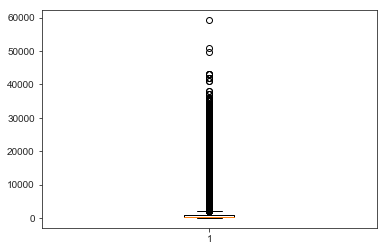

In [137]:
#draw the boxplot
plt.boxplot(sales_train['item_price']) 
new_outlier = 40000
sales_train = sales_train[sales_train['item_price'] < 40000]

In [150]:
#check
sales_train.item_price.describe()

count   2935834.00
mean        890.55
std        1717.98
min           0.07
25%         249.00
50%         399.00
75%         999.00
max       37991.00
Name: item_price, dtype: float64

In [149]:
#minus item_cnt_day?
sales_train['item_cnt_day'].describe()

count   2935834.00
mean          1.24
std           2.62
min         -22.00
25%           1.00
50%           1.00
75%           1.00
max        2169.00
Name: item_cnt_day, dtype: float64

In [148]:
#total 7,356 rows with minus value in item_cnt_day column
sales_train[sales_train.item_cnt_day < 0].count()

date              7356
date_block_num    7356
shop_id           7356
item_id           7356
item_price        7356
item_cnt_day      7356
dtype: int64

In [151]:
sales_train= sales_train[sales_train.item_cnt_day > 0]

I found out there are some minus item_cnt_day rows as well. They cannot be stolen or damaged items which are not to be sold. It is reasonable to exclude those even though there are total 7,356 rows. 

In [152]:
sales_train.describe() # now they are gone!

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2928478.00,2928478.00,2928478.00,2928478.00,2928478.00
mean,14.57,33.00,10200.27,889.17,1.25
std,9.42,16.23,6324.41,1715.64,2.62
min,0.00,0.00,0.00,0.07,1.00
25%,7.00,22.00,4477.00,249.00,1.00
50%,14.00,31.00,9355.00,399.00,1.00
75%,23.00,47.00,15691.00,999.00,1.00
max,33.00,59.00,22169.00,37991.00,2169.00


In [142]:
# Let's check the Shops dataset
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [47]:
# total 60 shops 
shops.shop_id.count() 

60

In [157]:
#group by month, shop id, and item id
#monthly mean item price
#monthly sum item_cnt_day
sales_train.groupby(['date_block_num','shop_id','item_id'])['date','item_price','item_cnt_day'] \
                    .agg({"date":["min","max"], "item_price": "mean", "item_cnt_day":"sum"})

date             item_price item_cnt_day
                                       min         max       mean          sum
date_block_num shop_id item_id                                                
0              0       32       03.01.2013  31.01.2013     221.00         6.00
                       33       03.01.2013  28.01.2013     347.00         3.00
                       35       31.01.2013  31.01.2013     247.00         1.00
                       43       31.01.2013  31.01.2013     221.00         1.00
                       51       13.01.2013  31.01.2013     128.50         2.00
                       61       10.01.2013  10.01.2013     195.00         1.00
                       75       17.01.2013  17.01.2013      76.00         1.00
                       88       16.01.2013  16.01.2013      76.00         1.00
                       95       06.01.2013  06.01.2013     193.00         1.00
                       96       10.01.2013  10.01.2013      70.00         1.00
                       98       04.01.2013  31.01.2013     268.00        25.00
                       111      17.01.2013  17.01.2013      89.00         1.00
                       149      11.01.2013  28.01.2013      99.00         3.00
                       151      16.01.2013  16.01.2013      75.00         1.00
                       153      09.01.2013  09.01.2013     258.00         1.00
                       198      10.01.2013  10.01.2013     112.00         1.00
                       210      05.01.2013  25.01.2013     118.00         2.00
                       282      04.01.2013  04.01.2013     109.00         1.00
                       306      22.01.2013  22.01.2013      59.00         1.00
                       351      21.01.2013  21.01.2013      89.00         1.00
                       421      07.01.2013  07.01.2013     162.00         1.00
                       438      31.01.2013  31.01.2013     162.00         1.00
                       482      09.01.2013  14.01.2013    1360.00         2.00
                       484      09.01.2013  30.01.2013     124.00         4.00
                       491      27.01.2013  27.01.2013     361.00         1.00
                       498      19.01.2013  19.01.2013     124.00         1.00
                       556      15.01.2013  25.01.2013      90.00         9.00
                       642      06.01.2013  20.01.2013      90.00         6.00
                       651      09.01.2013  25.01.2013      90.00         7.00
                       657      03.01.2013  18.01.2013      90.00         2.00
...                                    ...         ...        ...          ...
33             59      19894    23.10.2015  23.10.2015     199.00         1.00
                       19985    11.10.2015  11.10.2015     299.00         1.00
                       20303    07.10.2015  07.10.2015     399.00         1.00
                       20305    09.10.2015  09.10.2015     449.00         1.00
                       20335    23.10.2015  23.10.2015    1149.00         1.00
                       20355    30.10.2015  30.10.2015    1249.00         1.00
                       20392    06.10.2015  06.10.2015    2199.00         1.00
                       20604    20.10.2015  23.10.2015     999.00         2.00
                       20614    09.10.2015  09.10.2015    1099.00         1.00
                       20629    26.10.2015  26.10.2015    2399.00         1.00
                       20730    31.10.2015  31.10.2015     499.00         1.00
                       20751    10.10.2015  10.10.2015     699.00         1.00
                       20866    01.10.2015  31.10.2015     699.00         4.00
                       20949    02.10.2015  31.10.2015       5.00        19.00
                       21361    08.10.2015  08.10.2015    1999.00         1.00
                       21364    24.10.2015  24.10.2015     399.00         1.00
                       21369    10.10.2015  31.10.2015     169.00         2.00
         

#### Summary 
Time-series daily sales data 
- with 2,935,849 obs and 6 columns <br>
- consisting of data beginning from 01/2013 to 10/2015 <br>

Columns you should be careful of:
- `date`            - format in dd/mm/yy (will change the date format to mm/dd/yy for convenience)
- `date_block_num`  - index of date. ex) Jan 2013 - 0, Feb 2013 - 1
- `item_cnt_day`    - target variable y

### 2-2. Data Exploration (2) Items

In [20]:
# Obeservations of each dataset
print('Items:', items.shape[0])
print('Item Categories:', items_categories.shape[0])
print('Shops:',shops.shape[0])

Items: 22170
Item Categories: 84
Shops: 60


In [21]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [22]:
items_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


Even though rows were written in Russian, in fact not all of words were! I could meet some very familiar words such as PS4, XBOX, Blu-ray, MP3 etc.. I was so curious of what these Russians mean next to gaming products that I look up some of those at Google Translate.
- `Аксессуары` Accessories
- `Игровые консоли` Game consoles
- `Игры` - Game
- `Кино` - Movie
- `Карты оплаты` - Payment cards
- `Книги` - Books
- `Подарки` - Presents
- `Программы` - Programs
<br>

It seems like the source of data comes from retailers(shops) selling the variety of entertaining goods like games, movies, and books. 

In [50]:
# Total 84 item categories
items_categories['item_category_id'].count()

84

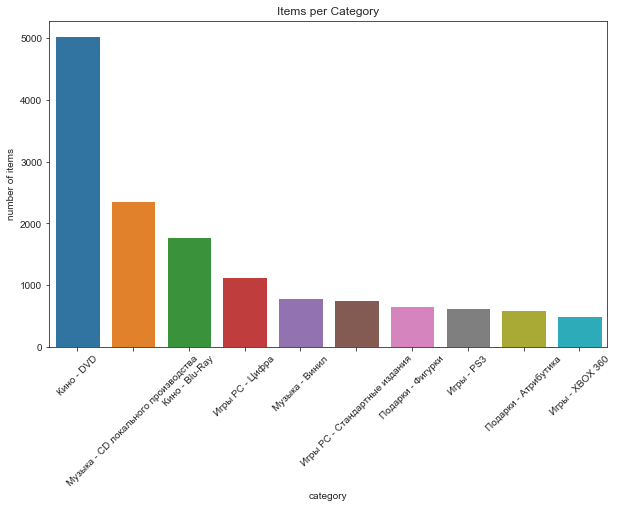

In [94]:
# Top 10 number of item categories 
itemsGroupByCategoryId = items.groupby(['item_category_id']).count()
itemsGroupByCategoryId = itemsGroupByCategoryId.sort_values(by='item_id', ascending = False)
itemsGroupByCategoryId = itemsGroupByCategoryId.drop(['item_name'], axis=1).iloc[0:10].reset_index()
itemsGroupByCategoryIdJoinedByName = itemsGroupByCategoryId.merge(items_categories, on = ["item_category_id"], how ='left')

sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
plt.figure(figsize=(10,6))

g = sns.barplot(itemsGroupByCategoryIdJoinedByName['item_category_name'], itemsGroupByCategoryIdJoinedByName['item_id'])
plt.title("Items per Category")
plt.ylabel("# of items")
plt.xlabel("Category")
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.show()

The barplot above is top 10 number of items per category. We can see there are more than 5,000 items in the Movie - DVD category.

### 3. Time-Series Modeling